# Введение

Рекомендательные системы — важнейший инструмент роста и удержания клиентов для онлайн-ритейла. Они увеличивают конверсию, средний чек и позволяют строить долгосрочные отношения с пользователями за счёт персональных предложений.

## 1.1 Постановка задачи

**Цель проекта:**  
Повысить ключевые бизнес-показатели интернет-магазина с помощью внедрения и сравнения базовых моделей рекомендательных систем.

**ML-задача:**  
Построить и сравнить baseline-модели, которые предсказывают, какие товары с наибольшей вероятностью заинтересуют пользователя (вероятность покупки на основе истории действий).

**Бизнес-контекст:**  
Высокие ML-метрики (Precision@K, Recall@K и др.) могут коррелировать с бизнес-метриками (конверсия, средний чек), но не всегда их гарантируют — поэтому важно анализировать оба типа показателей.

---

## 1.2 Описание датасета

В работе используется реальный датасет [RetailRocket Sample Dataset](https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset), включающий:

- **events.csv** — действия пользователей (просмотры, добавления в корзину, покупки)
- **item_properties_part1.csv**, **item_properties_part2.csv** — свойства товаров
- **category_tree.csv** — иерархия товарных категорий

**Ключевые особенности:**
- 2,7 млн событий
- 1,4 млн уникальных пользователей
- 235 тыс. товаров
- Данные максимально приближены к реальным задачам e-commerce

---

## 1.3 Цели исследования

- Провести первичный анализ и подготовку данных для моделирования.
- Реализовать и сравнить baseline-модели рекомендаций:
    - Модель на основе популярности товаров
    - Item-based co-occurrence модель
    - Модель матричной факторизации (LightFM)
- Оценить качество рекомендаций с помощью метрик Precision@K, Recall@K, MAP и NDCG.
- Сформулировать выводы о влиянии моделей на бизнес-метрики (конверсия, удержание, средний чек).

In [103]:
# Стандартные библиотеки
import os
from collections import Counter, defaultdict

# Научные и численные библиотеки
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Машинное обучение и рекомендательные системы
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k

In [104]:
# Проверка наличия необходимых файлов

data_dir = './data'
files = [
    'events.csv',
    'item_properties_part1.csv',
    'item_properties_part2.csv',
    'category_tree.csv'
]

print("Проверка наличия файлов:")

for file in files:
    filepath = os.path.join(data_dir, file)
    if os.path.exists(filepath):
        print(f"✅ {file} найден в {filepath}")
    else:
        print(f"❌ {file} НЕ НАЙДЕН!")

Проверка наличия файлов:
✅ events.csv найден в ./data/events.csv
✅ item_properties_part1.csv найден в ./data/item_properties_part1.csv
✅ item_properties_part2.csv найден в ./data/item_properties_part2.csv
✅ category_tree.csv найден в ./data/category_tree.csv


## Шаг 1. Обзор данных

На этом этапе мы загрузим основные файлы датасета, изучим их структуру, размеры и проведём первичный осмотр.  
Особое внимание уделим подсчёту уникальных пользователей, товаров и событий — это поможет оценить масштаб задачи и сложность будущих моделей.

In [105]:
# Загрузка данных
events = pd.read_csv('./data/events.csv')
item_props1 = pd.read_csv('./data/item_properties_part1.csv')
item_props2 = pd.read_csv('./data/item_properties_part2.csv')
category_tree = pd.read_csv('./data/category_tree.csv')

In [106]:
# Первые строки
display(events.head())
display(item_props1.head())
display(category_tree.head())

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [107]:
# Информация о структуре и пропусках
print("Информация о events.csv:")
events.info(show_counts=True)
print("\nИнформация о item_properties_part1.csv:")
item_props1.info(show_counts=True)
print("\nИнформация о item_properties_part2.csv:")
item_props2.info(show_counts=True)
print("\nИнформация о category_tree.csv:")
category_tree.info(show_counts=True)

Информация о events.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   timestamp      2756101 non-null  int64  
 1   visitorid      2756101 non-null  int64  
 2   event          2756101 non-null  object 
 3   itemid         2756101 non-null  int64  
 4   transactionid  22457 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB

Информация о item_properties_part1.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype 
---  ------     --------------     ----- 
 0   timestamp  10999999 non-null  int64 
 1   itemid     10999999 non-null  int64 
 2   property   10999999 non-null  object
 3   value      10999999 non-null  object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB

Информация о item

In [108]:
# Базовая статистика по уникальным значениям
print(f"Уникальных пользователей: {events['visitorid'].nunique()}")
print(f"Уникальных товаров в событиях: {events['itemid'].nunique()}")
print(f"Уникальных товаров в характеристиках: {pd.concat([item_props1['itemid'], item_props2['itemid']]).nunique()}")
print(f"Уникальных событий: {events['event'].nunique()}")
print(f"Всего событий: {len(events)}")
print(f"Типы событий: {events['event'].unique()}")

Уникальных пользователей: 1407580
Уникальных товаров в событиях: 235061
Уникальных товаров в характеристиках: 417053
Уникальных событий: 3
Всего событий: 2756101
Типы событий: ['view' 'addtocart' 'transaction']


#### Вывод

**Вывод по этапу "Обзор данных":**

- Датасет успешно загружен и содержит:
    - **2 756 101 событий** (events.csv)
    - **1 407 580 уникальных пользователей**
    - **235 061 уникальный товар в событиях**
    - **417 053 уникальных товаров в характеристиках** (item_properties_part1/2)
    - **3 типа событий:** просмотр (`view`), добавление в корзину (`addtocart`), покупка (`transaction`)
- В таблице событий:
    - Все столбцы заполнены, кроме `transactionid`, который используется только для покупок (22 457 непустых значений).
    - Структура: timestamp (время события), visitorid (ID пользователя), event (тип события), itemid (ID товара), transactionid (ID транзакции).
- Таблицы характеристик товаров содержат ~20 млн строк.
- В category_tree содержится 1 669 категорий, часть из которых — корневые (без parentid).
- Типы данных корректны, пропуски есть только там, где это ожидаемо.
- В item_properties встречается больше товаров, чем в событиях — значит, часть товаров не была замечена пользователями.
- Данные занимают значительный объём памяти (events — 105 МБ, item properties — ~600 МБ).

**Пропуски в данных:**
- Поля `timestamp`, `visitorid`, `event`, `itemid` — без пропусков.
- Поле `transactionid` заполнено только для событий типа `transaction` (покупка).
- В `category_tree` не заполнено поле `parentid` у корневых категорий.

**Заключение:**  
Структура и объём данных подтверждают, что RetailRocket Sample отлично подходит для задач рекомендательных систем в e-commerce.

## Шаг 2. Подготовка данных

На этом этапе проводится очистка и предварительная обработка данных:
- Проверяем корректность и читаемость названий столбцов;
- Находим и обрабатываем пропуски;
- Проверяем и устраняем дубликаты;
- Преобразуем временные метки в удобный формат;
- Создаём базовые временные признаки для последующего анализа.

In [109]:
# Проверка исходных столбцов
print('Столбцы до переименования:', events.columns.tolist())

# Переименование для единообразия
events = events.rename(columns={'visitorid': 'user_id', 'itemid': 'item_id', 'transactionid': 'transaction_id'})
item_props1 = item_props1.rename(columns={'itemid': 'item_id'})
item_props2 = item_props2.rename(columns={'itemid': 'item_id'})
category_tree = category_tree.rename(columns={'categoryid': 'category_id', 'parentid': 'parent_id'})

print('Столбцы после переименования:', events.columns.tolist())

Столбцы до переименования: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']
Столбцы после переименования: ['timestamp', 'user_id', 'event', 'item_id', 'transaction_id']


In [110]:
# Проверка пропусков
print('Пропуски в events:\n', events.isnull().sum())
print('Пропуски в item_properties_part1:\n', item_props1.isnull().sum())
print('Пропуски в item_properties_part2:\n', item_props2.isnull().sum())
print('Пропуски в category_tree:\n', category_tree.isnull().sum())

Пропуски в events:
 timestamp               0
user_id                 0
event                   0
item_id                 0
transaction_id    2733644
dtype: int64
Пропуски в item_properties_part1:
 timestamp    0
item_id      0
property     0
value        0
dtype: int64
Пропуски в item_properties_part2:
 timestamp    0
item_id      0
property     0
value        0
dtype: int64
Пропуски в category_tree:
 category_id     0
parent_id      25
dtype: int64


In [111]:
# Проверка и удаление дубликатов
n_duplicates = events.duplicated().sum()
print(f'Дубликатов в events: {n_duplicates}')
events = events.drop_duplicates()
print(f'Размер после удаления дубликатов: {events.shape} (удалено {n_duplicates} строк)')

Дубликатов в events: 460
Размер после удаления дубликатов: (2755641, 5) (удалено 460 строк)


In [112]:
# Преобразование timestamp в datetime
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
item_props1['datetime'] = pd.to_datetime(item_props1['timestamp'], unit='ms')
item_props2['datetime'] = pd.to_datetime(item_props2['timestamp'], unit='ms')

print('Диапазон дат в events:', events['datetime'].min(), '-', events['datetime'].max())

Диапазон дат в events: 2015-05-03 03:00:04.384000 - 2015-09-18 02:59:47.788000


In [113]:
# Создание новых временных признаков
events['date'] = events['datetime'].dt.date
events['hour'] = events['datetime'].dt.hour
events['weekday'] = events['datetime'].dt.weekday  # 0 - понедельник, 6 - воскресенье

print(events[['datetime', 'date', 'hour', 'weekday']].head())

                 datetime        date  hour  weekday
0 2015-06-02 05:02:12.117  2015-06-02     5        1
1 2015-06-02 05:50:14.164  2015-06-02     5        1
2 2015-06-02 05:13:19.827  2015-06-02     5        1
3 2015-06-02 05:12:35.914  2015-06-02     5        1
4 2015-06-02 05:02:17.106  2015-06-02     5        1


**Вывод по этапу "Подготовка данных":**

- **Названия столбцов** приведены к единому стилю (`user_id`, `item_id`, `category_id`).
- **Пропуски** есть только в `transaction_id` (ожидаемо) и `parent_id` (корневые категории).
- **Дубликаты** в events.csv обнаружены и удалены; в остальных таблицах отсутствуют.
- **Временные метки** преобразованы в datetime; диапазон событий: **2015-05-03** — **2015-09-18**.
- Созданы признаки: дата, час, день недели — пригодятся для анализа и feature engineering.
- Данные чистые и готовы для EDA и построения baseline-моделей.

**Итог:**  
Данные полностью подготовлены и подходят для дальнейшего анализа и построения моделей.

## Шаг 3. Изучение и проверка данных (EDA)

На этом этапе мы изучим основные распределения в данных:
- Распределение событий (`view`, `addtocart`, `transaction`);
- Активность пользователей и товаров;
- Временные закономерности (часы, дни недели, тренды);
- Свежесть и полноту данных.

Анализ поможет выявить потенциальные проблемы (например, cold start) и заложить основу для построения признаков и моделей.

### 3.1 Распределение событий по типам

Изучим, как распределены события по типам (`view`, `addtocart`, `transaction`).

In [114]:
# Подсчёт количества и долей событий по типам
event_counts = events['event'].value_counts()
event_percent = events['event'].value_counts(normalize=True) * 100

print("Распределение событий по типам:")
for event in event_counts.index:
    count = event_counts[event]
    percent = event_percent[event]
    print(f"- {event:<12}: {count:>8,} ({percent:>5.2f}%)")

Распределение событий по типам:
- view        : 2,664,218 (96.68%)
- addtocart   :   68,966 ( 2.50%)
- transaction :   22,457 ( 0.81%)


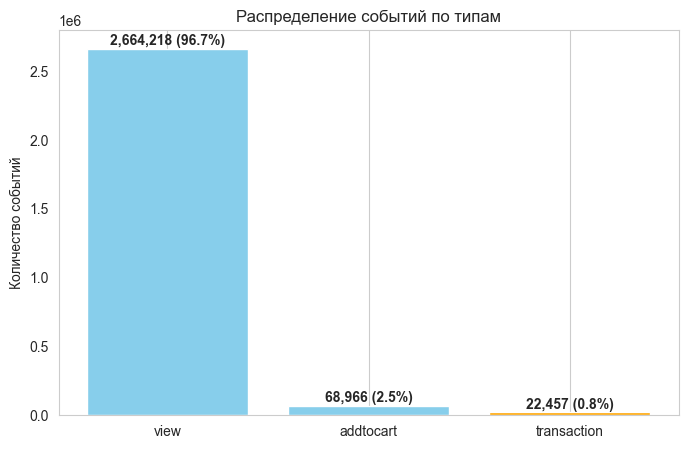

In [115]:
# Визуализация распределения событий по типам
colors = ['skyblue' if e != 'transaction' else 'orange' for e in event_counts.index]
labels = event_counts.index

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, event_counts, color=colors)
plt.title('Распределение событий по типам')
plt.ylabel('Количество событий')
plt.xticks(rotation=0)
plt.grid(axis='y')

for i, (v, p) in enumerate(zip(event_counts, event_percent)):
    plt.text(i, v + 5000, f'{v:,} ({p:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

**Выводы по распределению событий:**

- `view` (просмотры) — **96.7%** всех событий.
- `addtocart` (добавления в корзину) — **2.5%**.
- `transaction` (покупки) — **0.8%**.
- Классическая воронка e-commerce: почти все события — просмотры, до покупки доходит малая часть.
- Низкая конверсия требует специальных подходов: балансировка классов, таргет на покупки (`transaction`).
- Стандартные метрики (accuracy) здесь не информативны — нужны метрики вроде HitRate@K, Precision@K, Recall@K, NDCG@K.

### 3.2 Анализ активности пользователей

Проверим, сколько действий в среднем совершает один пользователь, и насколько сильно распределение "хвостатое".

In [116]:
# Количество событий на пользователя
user_event_counts = events['user_id'].value_counts()

print(f"Медианное количество событий на пользователя: {user_event_counts.median()}")
print(f"Среднее количество событий на пользователя: {user_event_counts.mean():.2f}")
print(f"Пользователей с 1 событием: {(user_event_counts == 1).sum()} ({(user_event_counts == 1).mean()*100:.2f}%)")
print(f"Пользователей с >=5 событиями: {(user_event_counts >= 5).sum()} ({(user_event_counts >= 5).mean()*100:.2f}%)")
print(f"Пользователей с >=10 событиями: {(user_event_counts >= 10).sum()} ({(user_event_counts >= 10).mean()*100:.2f}%)")
print(f"Пользователей с >100 событиями: {(user_event_counts > 100).sum()} ({(user_event_counts > 100).mean()*100:.4f}%)")

Медианное количество событий на пользователя: 1.0
Среднее количество событий на пользователя: 1.96
Пользователей с 1 событием: 1001591 (71.16%)
Пользователей с >=5 событиями: 81590 (5.80%)
Пользователей с >=10 событиями: 23224 (1.65%)
Пользователей с >100 событиями: 408 (0.0290%)


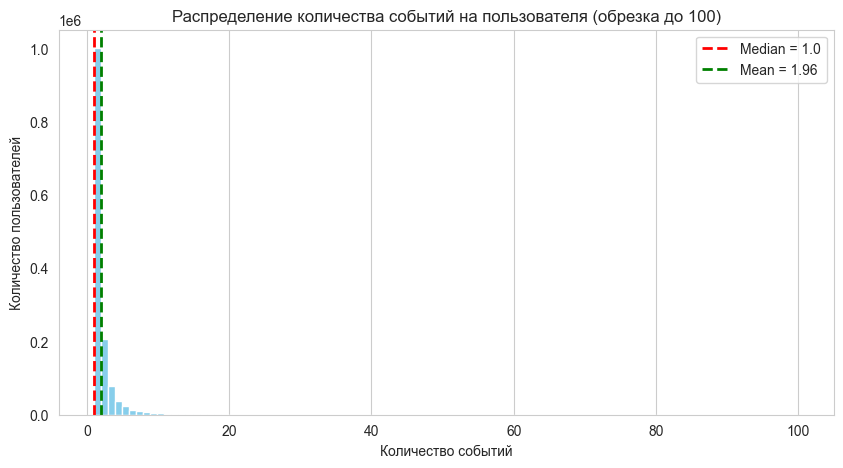

In [117]:
# Гистограмма активности пользователей (до 100 событий)
plt.figure(figsize=(10, 5))
user_event_counts.clip(upper=100).hist(bins=100, color='skyblue')
plt.axvline(user_event_counts.median(), color='red', linestyle='dashed', linewidth=2, label=f'Median = {user_event_counts.median()}')
plt.axvline(user_event_counts.mean(), color='green', linestyle='dashed', linewidth=2, label=f'Mean = {user_event_counts.mean():.2f}')
plt.title('Распределение количества событий на пользователя (обрезка до 100)')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(axis='y')
plt.show()

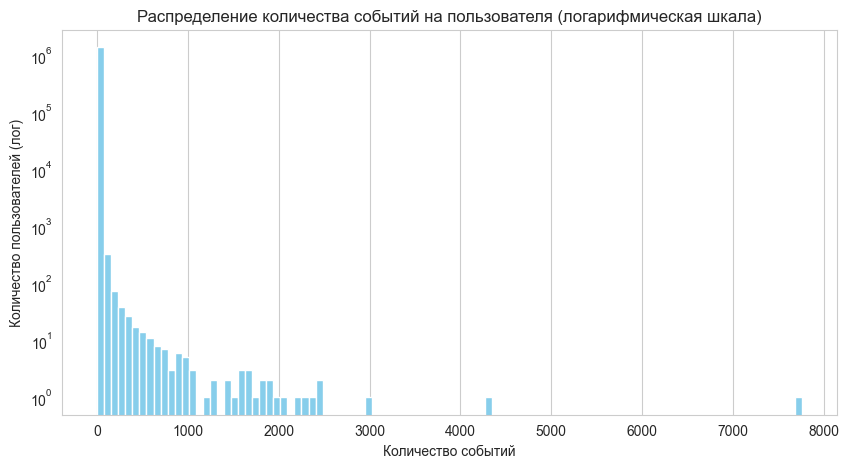

In [118]:
# Логарифмическая гистограмма активности пользователей
plt.figure(figsize=(10, 5))
user_event_counts.hist(bins=100, color='skyblue')
plt.yscale('log')
plt.title('Распределение количества событий на пользователя (логарифмическая шкала)')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей (лог)')
plt.grid(axis='y')
plt.show()

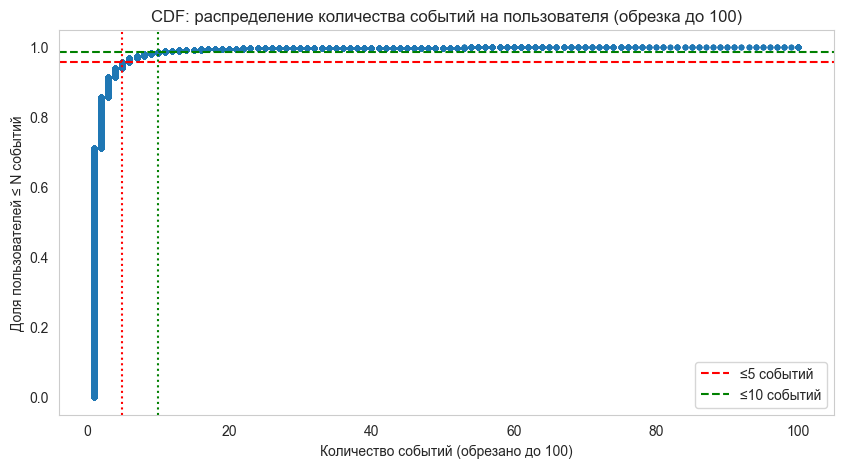

In [119]:
# CDF: кумулятивное распределение событий на пользователя (обрезка до 100)
sorted_counts = np.sort(user_event_counts.clip(upper=100))
cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

plt.figure(figsize=(10, 5))
plt.plot(sorted_counts, cdf, marker='.', linestyle='none')
plt.axhline(y=(user_event_counts <= 5).mean(), color='red', linestyle='dashed', label='≤5 событий')
plt.axhline(y=(user_event_counts <= 10).mean(), color='green', linestyle='dashed', label='≤10 событий')
plt.axvline(x=5, color='red', linestyle='dotted')
plt.axvline(x=10, color='green', linestyle='dotted')
plt.title('CDF: распределение количества событий на пользователя (обрезка до 100)')
plt.xlabel('Количество событий (обрезано до 100)')
plt.ylabel('Доля пользователей ≤ N событий')
plt.legend()
plt.grid()
plt.show()

**Выводы по активности пользователей:**

- Медиана — 1, среднее — 1.96 действия на пользователя.
- 71% пользователей — только одно действие (one-timers).
- 5.8% — ≥5 событий, 1.65% — ≥10 событий.
- Ядро активных пользователей мало, основной объём — пассивные.
- Признаки активности будут использоваться в моделях, cold start — важная проблема.

### 3.3 Анализ активности товаров

Рассмотрим, как часто взаимодействуют с товарами и насколько сильно выражен "long tail".

In [120]:
# Количество событий на товар
item_event_counts = events['item_id'].value_counts()

print(f"Медианное количество событий на товар: {item_event_counts.median()}")
print(f"Среднее количество событий на товар: {item_event_counts.mean():.2f}")
print(f"Товаров с 1 событием: {(item_event_counts == 1).sum()} ({(item_event_counts == 1).mean()*100:.2f}%)")
print(f"Товаров с >=5 событиями: {(item_event_counts >= 5).sum()} ({(item_event_counts >= 5).mean()*100:.2f}%)")
print(f"Товаров с >=10 событиями: {(item_event_counts >= 10).sum()} ({(item_event_counts >= 10).mean()*100:.2f}%)")
print(f"Товаров с >100 событиями: {(item_event_counts > 100).sum()} ({(item_event_counts > 100).mean()*100:.2f}%)")

Медианное количество событий на товар: 3.0
Среднее количество событий на товар: 11.72
Товаров с 1 событием: 73616 (31.32%)
Товаров с >=5 событиями: 90942 (38.69%)
Товаров с >=10 событиями: 55123 (23.45%)
Товаров с >100 событиями: 4164 (1.77%)


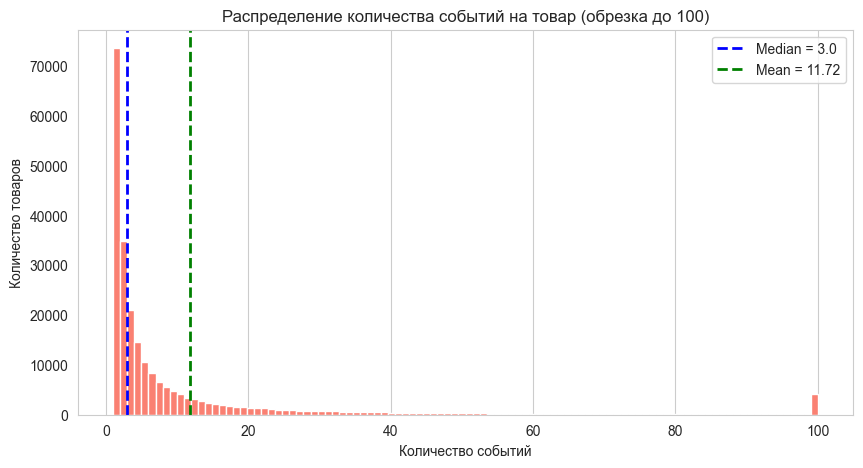

In [121]:
# Гистограмма активности товаров (обрезка до 100)
plt.figure(figsize=(10, 5))
item_event_counts.clip(upper=100).hist(bins=100, color='salmon')
plt.axvline(item_event_counts.median(), color='blue', linestyle='dashed', linewidth=2, label=f'Median = {item_event_counts.median()}')
plt.axvline(item_event_counts.mean(), color='green', linestyle='dashed', linewidth=2, label=f'Mean = {item_event_counts.mean():.2f}')
plt.title('Распределение количества событий на товар (обрезка до 100)')
plt.xlabel('Количество событий')
plt.ylabel('Количество товаров')
plt.legend()
plt.grid(axis='y')
plt.show()

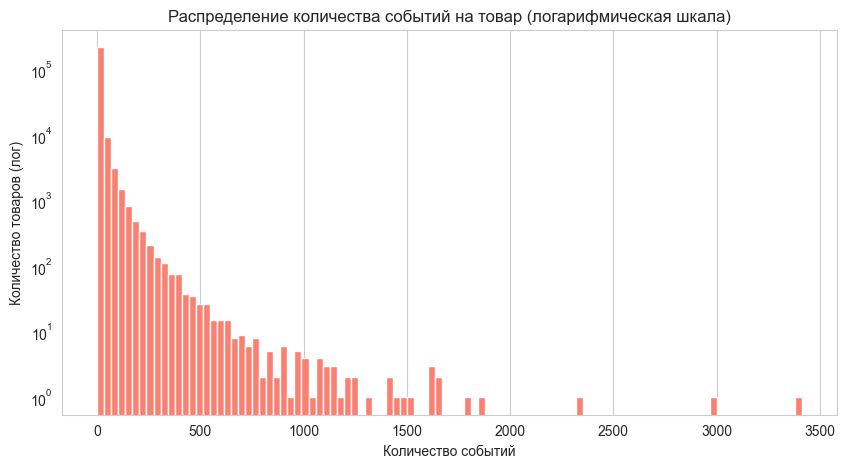

In [122]:
# Логарифмическая гистограмма активности товаров
plt.figure(figsize=(10, 5))
item_event_counts.hist(bins=100, color='salmon')
plt.yscale('log')
plt.title('Распределение количества событий на товар (логарифмическая шкала)')
plt.xlabel('Количество событий')
plt.ylabel('Количество товаров (лог)')
plt.grid(axis='y')
plt.show()

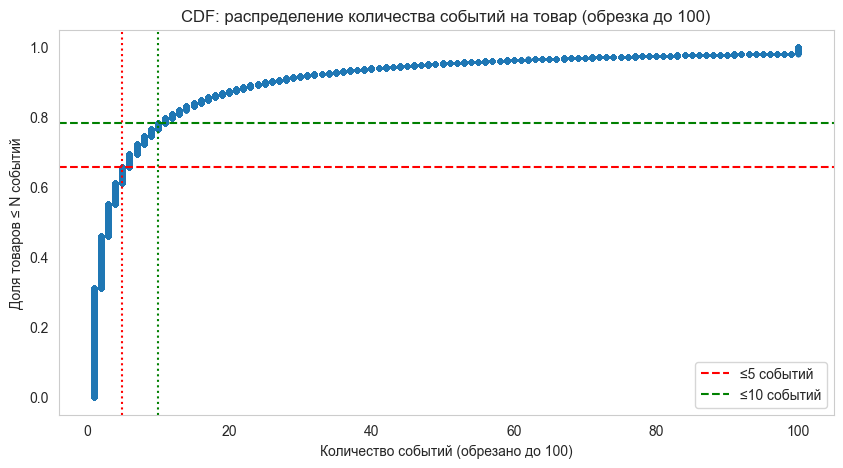

In [123]:
# CDF: кумулятивное распределение событий на товар (обрезка до 100)
sorted_item_counts = np.sort(item_event_counts.clip(upper=100).values)
cdf_items = np.arange(len(sorted_item_counts)) / len(sorted_item_counts)

plt.figure(figsize=(10, 5))
plt.plot(sorted_item_counts, cdf_items, marker='.', linestyle='none')

percent_le_5 = (item_event_counts <= 5).mean()
percent_le_10 = (item_event_counts <= 10).mean()
plt.axhline(y=percent_le_5, color='red', linestyle='dashed', label='≤5 событий')
plt.axhline(y=percent_le_10, color='green', linestyle='dashed', label='≤10 событий')

plt.axvline(x=5, color='red', linestyle='dotted')
plt.axvline(x=10, color='green', linestyle='dotted')

plt.title('CDF: распределение количества событий на товар (обрезка до 100)')
plt.xlabel('Количество событий (обрезано до 100)')
plt.ylabel('Доля товаров ≤ N событий')
plt.legend()
plt.grid()
plt.show()

**Выводы по активности товаров:**

- Медиана — 3, среднее — 11.72 события на товар.
- 31% товаров имеют только 1 взаимодействие.
- Только 38.7% — ≥5 событий, 23.5% — ≥10 событий.
- Выражен длинный хвост: малое число популярных товаров собирает большую часть событий.
- Для baseline используем все товары, для продвинутых моделей можно фильтровать по активности.

### 3.4 Анализ временных закономерностей

Рассмотрим распределение событий по времени: часам, дням недели и датам.

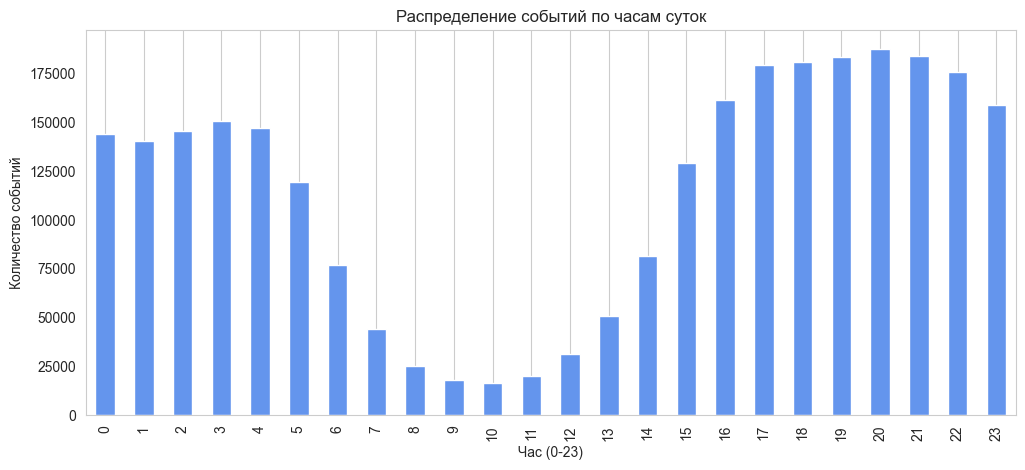

In [124]:
# Распределение событий по часам
plt.figure(figsize=(12, 5))
events['hour'].value_counts().sort_index().plot(kind='bar', color='cornflowerblue')
plt.title('Распределение событий по часам суток')
plt.xlabel('Час (0-23)')
plt.ylabel('Количество событий')
plt.grid(axis='y')
plt.show()

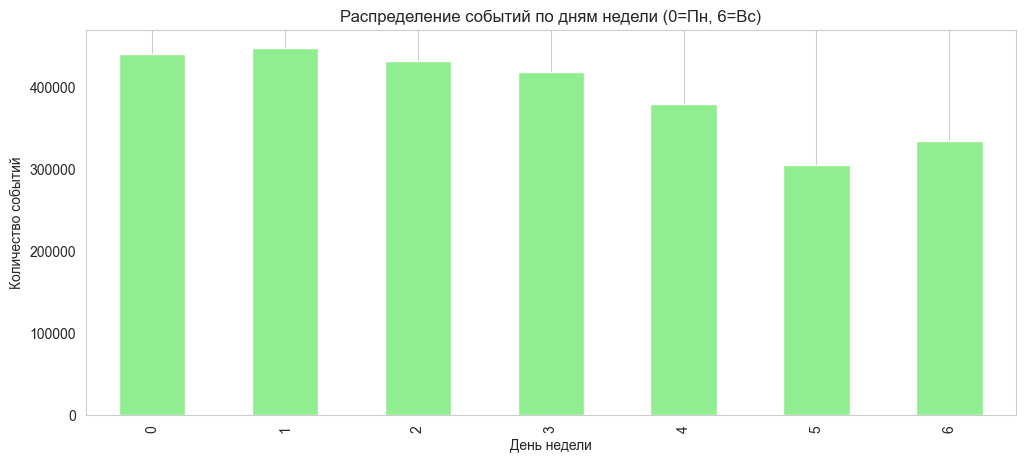

In [125]:
# Распределение событий по дням недели
plt.figure(figsize=(12, 5))
events['weekday'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Распределение событий по дням недели (0=Пн, 6=Вс)')
plt.xlabel('День недели')
plt.ylabel('Количество событий')
plt.grid(axis='y')
plt.show()

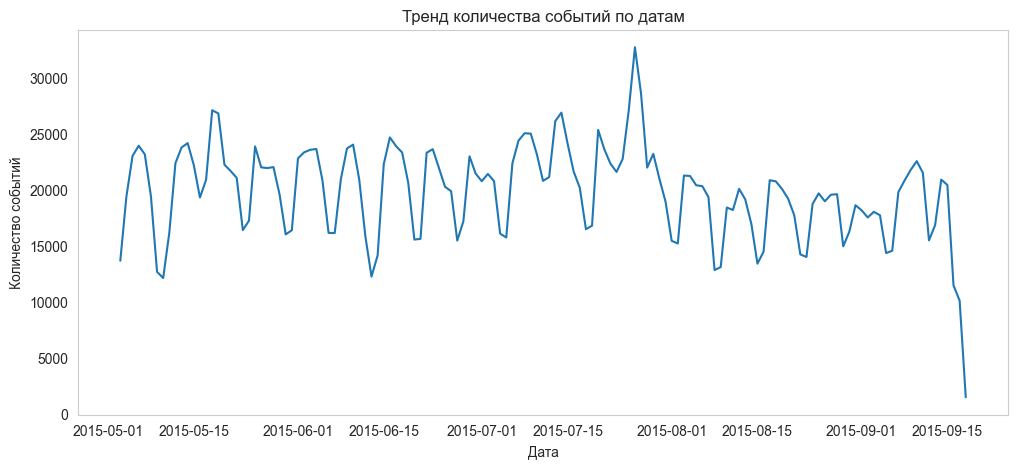

In [126]:
# Тренд событий по датам
plt.figure(figsize=(12, 5))
events.groupby('date').size().plot()
plt.title('Тренд количества событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid()
plt.show()

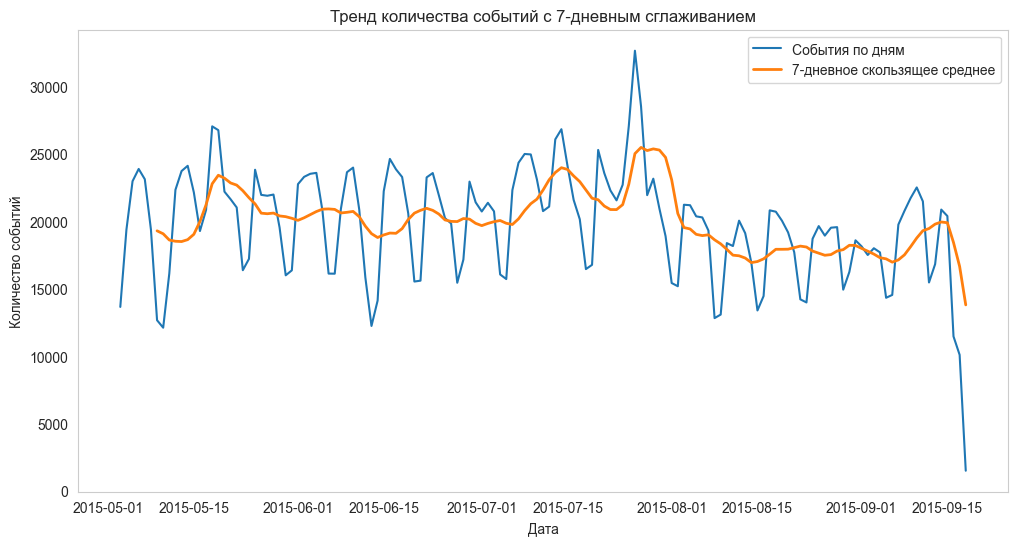

In [127]:
# Скользящее среднее для тренда
plt.figure(figsize=(12, 6))
event_counts_by_date = events.groupby('date').size()
event_counts_by_date.plot(label='События по дням')
event_counts_by_date.rolling(window=7).mean().plot(label='7-дневное скользящее среднее', linewidth=2)
plt.title('Тренд количества событий с 7-дневным сглаживанием')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend()
plt.grid()
plt.show()

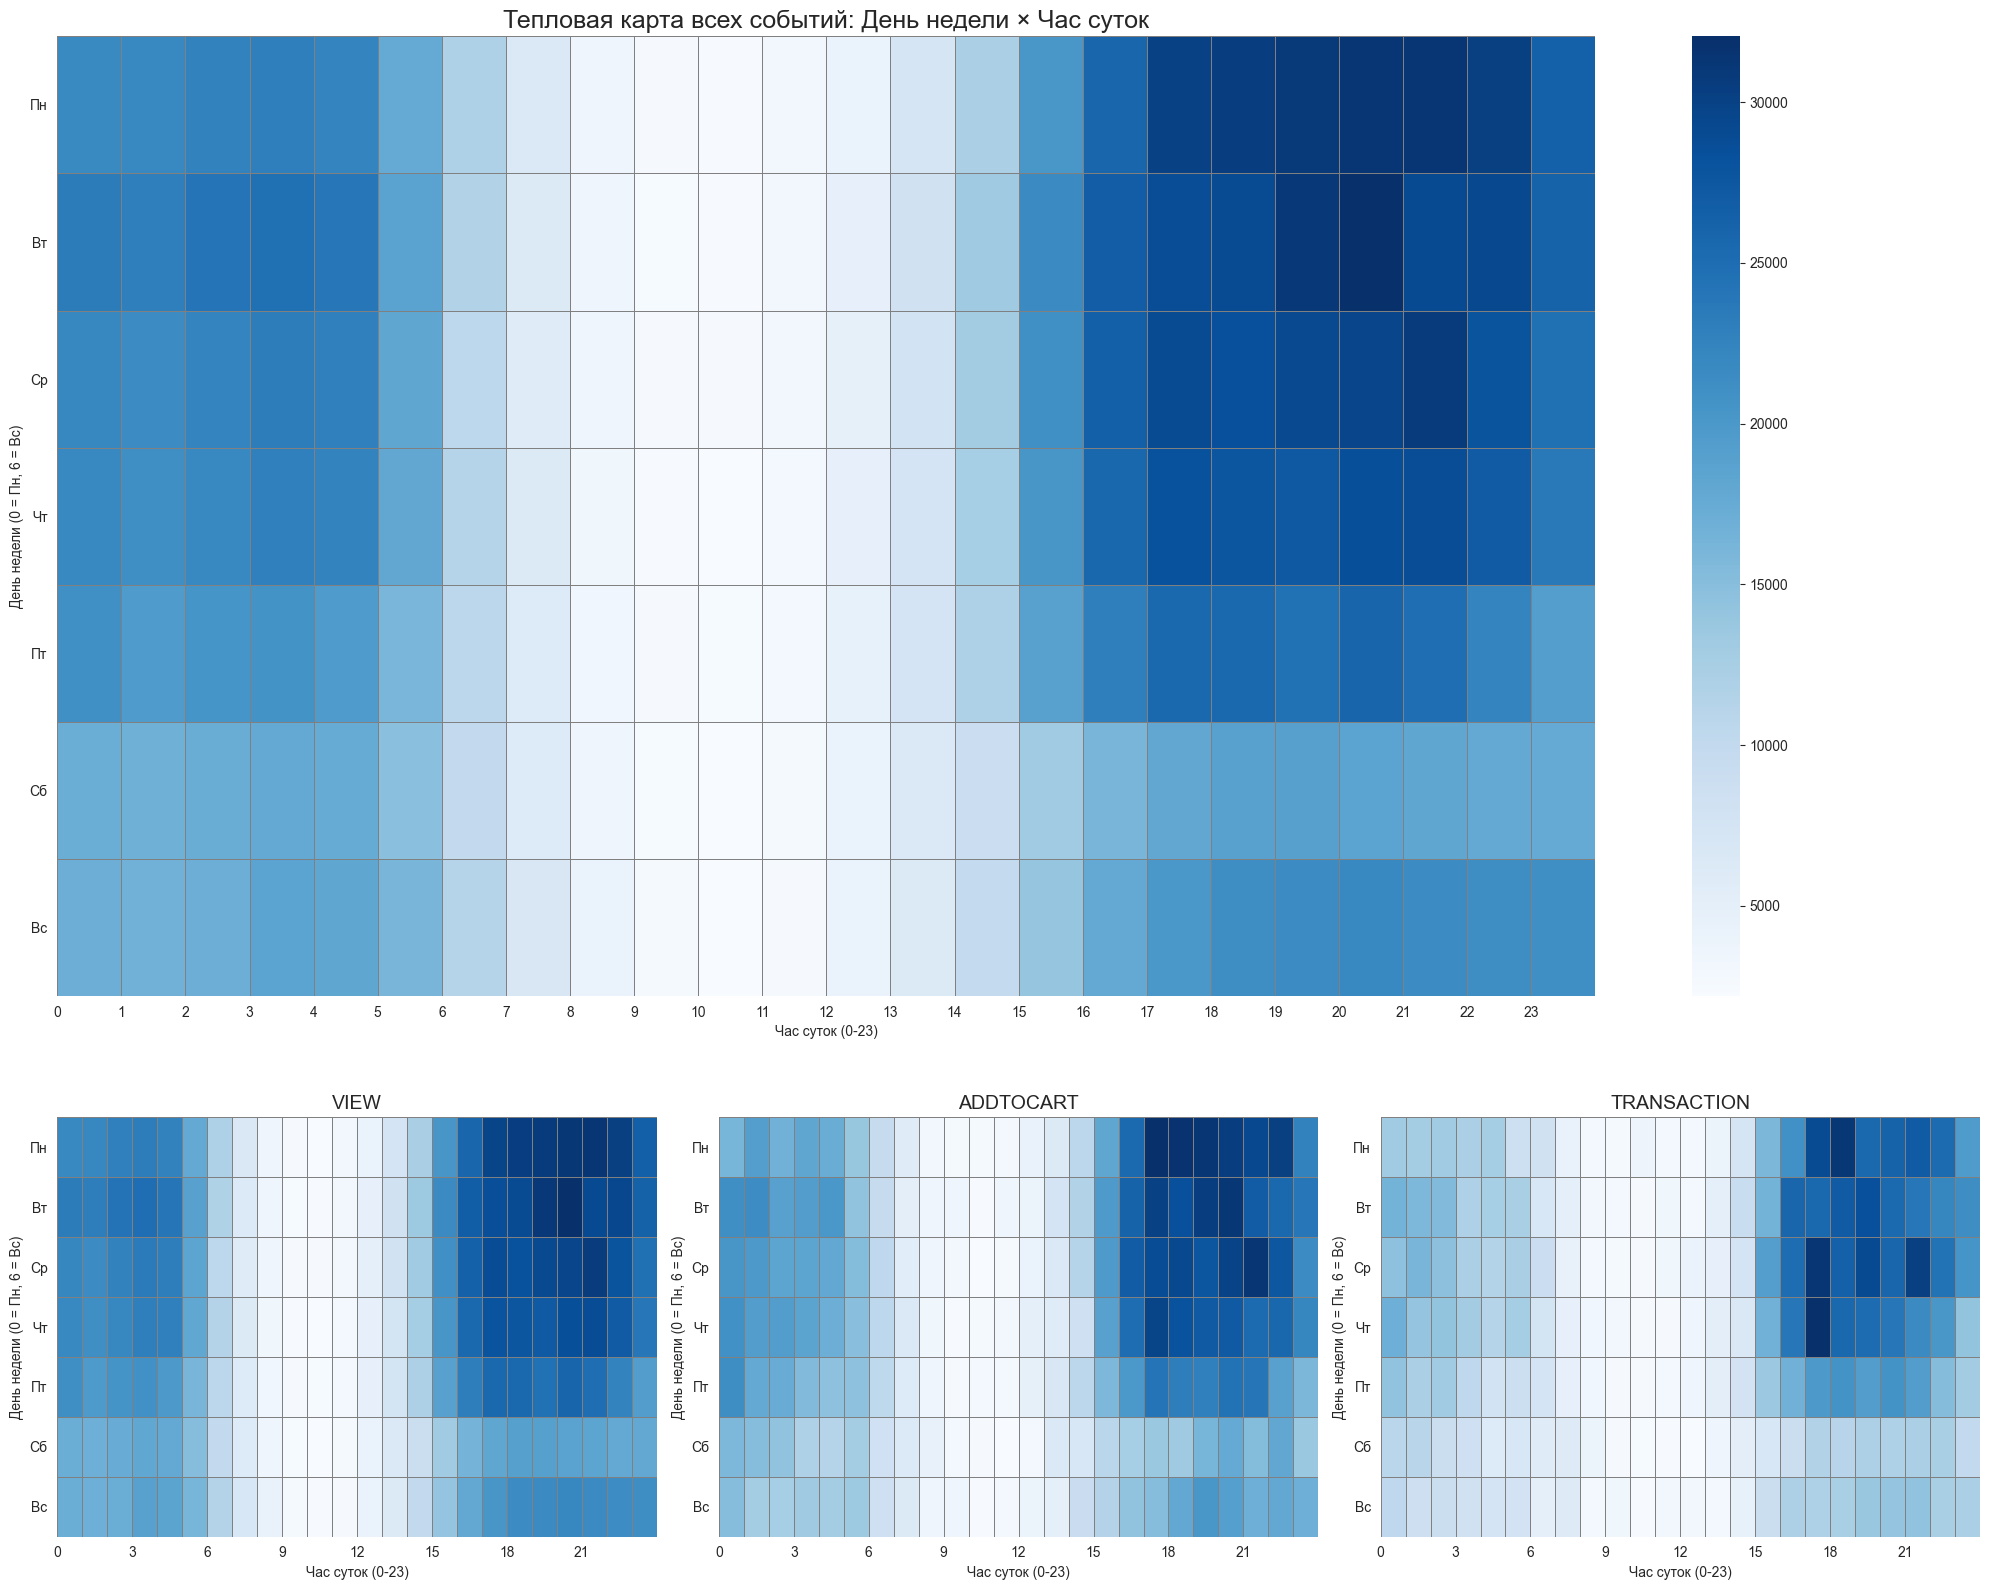

In [128]:
# Тепловая карта активности: день недели × час суток для всех событий и по типам
heatmap_all = events.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

# Для каждого типа события
heatmaps = {}
for event in ['view', 'addtocart', 'transaction']:
    subset = events[events['event'] == event]
    heatmaps[event] = subset.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

fig = plt.figure(figsize=(20, 16))  # Большой размер

# Главная тепловая карта
ax_main = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
sns.heatmap(heatmap_all, cmap='Blues', linewidths=0.5, linecolor='gray', ax=ax_main, cbar=True)
ax_main.set_title('Тепловая карта всех событий: День недели × Час суток', fontsize=18)
ax_main.set_xlabel('Час суток (0-23)')
ax_main.set_ylabel('День недели (0 = Пн, 6 = Вс)')
ax_main.set_yticks([i + 0.5 for i in range(7)])
ax_main.set_yticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], rotation=0)
ax_main.set_xticks(range(0, 24, 1))
ax_main.set_xticklabels(range(0, 24, 1), rotation=0)

# Отдельные тепловые карты по событиям
for idx, (event, data) in enumerate(heatmaps.items()):
    ax = plt.subplot2grid((3, 3), (2, idx))
    sns.heatmap(data, cmap='Blues', linewidths=0.5, linecolor='gray', ax=ax, cbar=False)
    ax.set_title(f'{event.upper()}', fontsize=14)
    ax.set_xlabel('Час суток (0-23)')
    ax.set_ylabel('День недели (0 = Пн, 6 = Вс)')
    ax.set_yticks([i + 0.5 for i in range(7)])
    ax.set_yticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], rotation=0)
    ax.set_xticks(range(0, 24, 3))
    ax.set_xticklabels(range(0, 24, 3), rotation=0)

plt.tight_layout(h_pad=4)
plt.show()

**Выводы по временным закономерностям:**

- Пик активности — вечер (17:00–22:00) и ночь (0:00–4:00).
- Максимум — начало недели, минимум — суббота.
- Покупки и корзина сконцентрированы в будние вечера, просмотры — более равномерно.
- Временные признаки и недельные паттерны обязательно добавим в модели.

### Вывод по этапу EDA

EDA показал:
- Данные имеют выраженную e-commerce воронку (97% просмотров, 0.8% покупок).
- 71% пользователей — только одно действие, cold start-эффект выражен резко.
- 31% товаров — только 1 взаимодействие, наблюдается длинный хвост.
- Активность максимальна в вечера будней, выражена недельная сезонность.
- Для baseline используем все товары и события, для продвинутых моделей — можно фильтровать по активности.
- Временные признаки — обязательны для feature engineering.

Данные содержат все классические вызовы рекомендательных систем, а выявленные паттерны лягут в основу выбора алгоритмов и feature engineering.

## Шаг 4. Воронка событий и пользовательские пути

На этом этапе:
- Анализируем, как пользователи проходят путь от просмотра до покупки (`view → addtocart → transaction`);
- Визуализируем воронку и оцениваем конверсии;
- Изучаем, какие товары "ведут" пользователей по воронке;
- Формулируем бизнес-инсайты для построения baseline и продвинутых моделей.

**Цель:**  
Понять, где теряются пользователи, какие товары и действия наиболее критичны для роста конверсии и качества рекомендаций.

### 4.1 Воронка событий: от просмотра к покупке

Рассчитаем, сколько уникальных пользователей проходит каждый этап воронки:
- Просмотр товара (`view`)
- Добавление в корзину (`addtocart`)
- Покупка (`transaction`)

Визуализируем воронку и выделим ключевые потери.

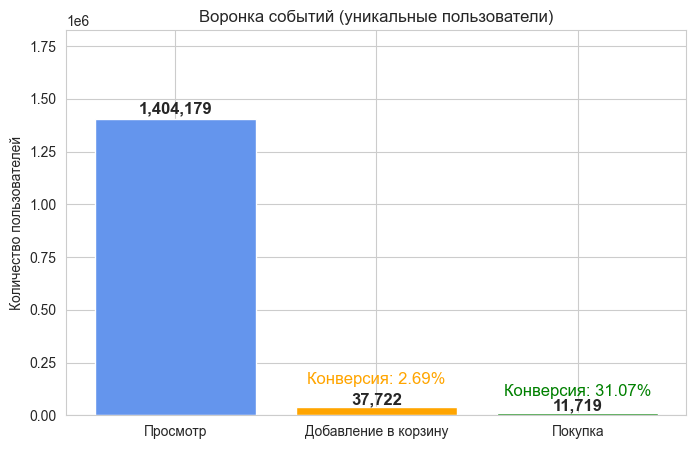

In [129]:
# Подсчёт уникальных пользователей на каждом этапе
n_view = events[events['event'] == 'view']['user_id'].nunique()
n_cart = events[events['event'] == 'addtocart']['user_id'].nunique()
n_buy  = events[events['event'] == 'transaction']['user_id'].nunique()

stages = ['Просмотр', 'Добавление в корзину', 'Покупка']
counts = [n_view, n_cart, n_buy]

# Barplot с подписями
plt.figure(figsize=(8, 5))
bars = plt.bar(stages, counts, color=['cornflowerblue', 'orange', 'green'])
plt.title('Воронка событий (уникальные пользователи)')
plt.ylabel('Количество пользователей')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()*1.01, f'{count:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.text(1, counts[1]*4, f'Конверсия: {counts[1]/counts[0]:.2%}', ha='center', color='orange', fontsize=12)
plt.text(2, counts[2]*8, f'Конверсия: {counts[2]/counts[1]:.2%}', ha='center', color='green', fontsize=12)
plt.ylim(0, max(counts)*1.3)
plt.show()

In [130]:
import plotly.graph_objects as go

fig = go.Figure(go.Funnel(
    y = stages,
    x = counts,
    textinfo = "value+percent initial+percent previous"
))
fig.update_layout(title="Воронка событий (уникальные пользователи, plotly)")
fig.show()

**Анализ конверсий по этапам:**
- Конверсия просмотра в добавление в корзину крайне низкая (~2.7%).
- Конверсия добавления в корзину в покупку — выше (~31%).
- Общая конверсия от просмотра до покупки — менее 1%.

**Основное узкое место:**  
97% пользователей не совершают целевое действие после просмотра — это критическая точка для роста эффективности рекомендаций и интерфейса.

### 4.2 Активность пользователей: сколько товаров добавляют и покупают

Посчитаем, сколько товаров в среднем и медиане добавляет в корзину/покупает один пользователь, и построим распределения.

В среднем пользователь добавляет в корзину: 1.83 товаров (медиана: 1)
В среднем пользователь покупает: 1.92 товаров (медиана: 1)


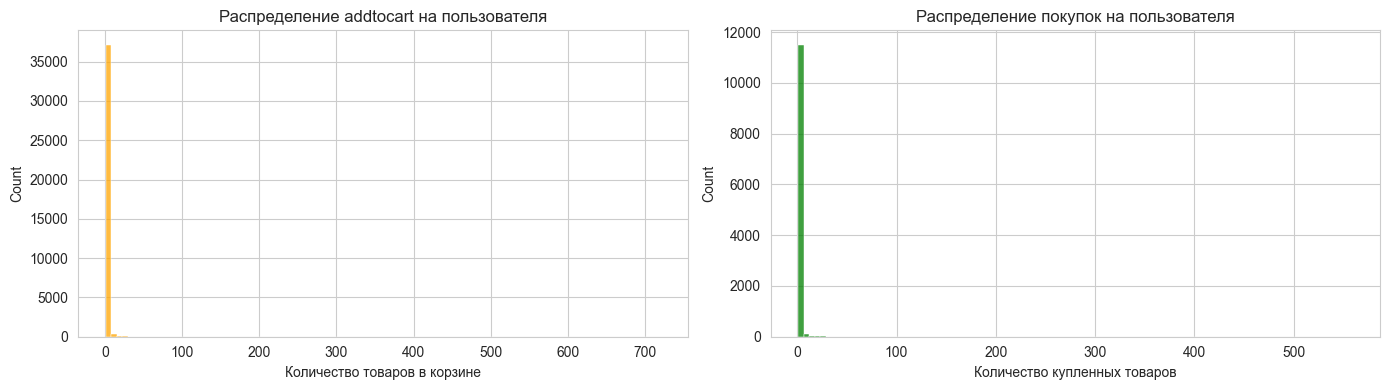

In [131]:
# Среднее и медианное число событий на пользователя
cart_per_user = events[events['event'] == 'addtocart'].groupby('user_id')['item_id'].count()
buy_per_user = events[events['event'] == 'transaction'].groupby('user_id')['item_id'].count()

print(f"В среднем пользователь добавляет в корзину: {cart_per_user.mean():.2f} товаров (медиана: {cart_per_user.median():.0f})")
print(f"В среднем пользователь покупает: {buy_per_user.mean():.2f} товаров (медиана: {buy_per_user.median():.0f})")

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(cart_per_user, bins=100, ax=axs[0], color='orange')
axs[0].set_title('Распределение addtocart на пользователя')
axs[0].set_xlabel('Количество товаров в корзине')
sns.histplot(buy_per_user, bins=100, ax=axs[1], color='green')
axs[1].set_title('Распределение покупок на пользователя')
axs[1].set_xlabel('Количество купленных товаров')
plt.tight_layout()
plt.show()

In [132]:
# Дополнительный срез: пользователи с >=5 действиями
active_cart = cart_per_user[cart_per_user >= 5]
active_buy = buy_per_user[buy_per_user >= 5]

print(f"Активные пользователи (≥5 добавлений в корзину): {len(active_cart)}")
print(f"Активные пользователи (≥5 покупок): {len(active_buy)}")
print(f"Среднее число покупок у активных: {active_buy.mean():.2f} (медиана: {active_buy.median():.0f})")

Активные пользователи (≥5 добавлений в корзину): 1632
Активные пользователи (≥5 покупок): 377
Среднее число покупок у активных: 21.36 (медиана: 8)


- Активные пользователи совершают в среднем больше покупок.
- Их стоит выделять в отдельные сегменты для продвинутых моделей персонализации.

### 4.3 Топ-товары и их роль в воронке

Изучим топ-10 товаров на каждом этапе (просмотр, добавление в корзину, покупка) и их пересечение.


Топ-10 товаров для события view:
187946    3410
461686    2538
5411      2325
370653    1854
219512    1740
298009    1642
96924     1633
309778    1565
257040    1531
384302    1528
Name: item_id, dtype: int64

Топ-10 товаров для события addtocart:
461686    304
312728    161
409804    152
320130    141
29196     135
7943       97
48030      95
441852     90
445351     89
257040     89
Name: item_id, dtype: int64

Топ-10 товаров для события transaction:
461686    133
119736     97
213834     92
312728     46
7943       46
445351     45
48030      41
420960     38
248455     38
17478      37
Name: item_id, dtype: int64
Товары во всех топах: {461686}
Только в просмотрах: {5411, 187946, 384302, 309778, 219512, 298009, 96924, 370653}
Только в покупках: {420960, 17478, 248455, 213834, 119736}


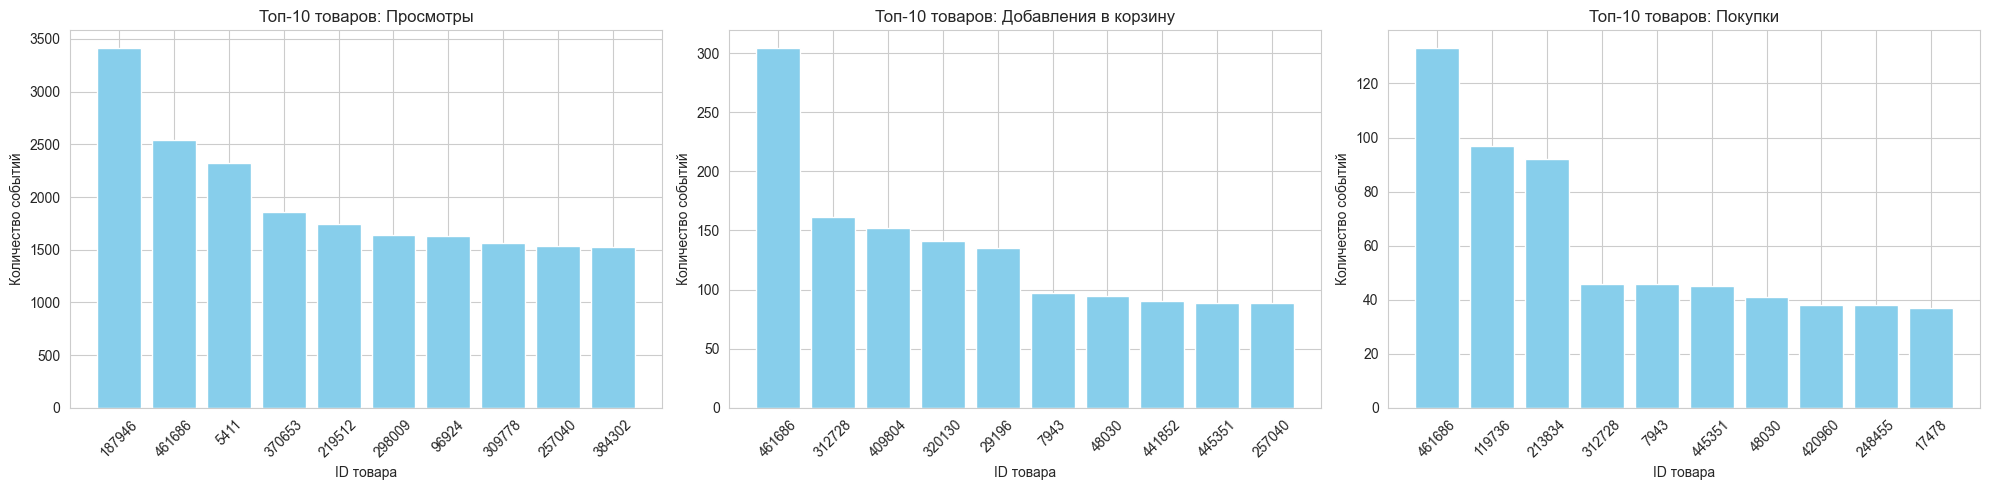

In [133]:
# Топ-10 товаров по каждому событию
for event in ['view', 'addtocart', 'transaction']:
    top_items = events[events['event'] == event]['item_id'].value_counts().head(10)
    print(f'\nТоп-10 товаров для события {event}:')
    print(top_items)

# Пересечение топов
top_view = set(events[events['event'] == 'view']['item_id'].value_counts().head(10).index)
top_cart = set(events[events['event'] == 'addtocart']['item_id'].value_counts().head(10).index)
top_buy  = set(events[events['event'] == 'transaction']['item_id'].value_counts().head(10).index)

print("Товары во всех топах:", top_view & top_cart & top_buy)
print("Только в просмотрах:", top_view - (top_cart | top_buy))
print("Только в покупках:", top_buy - (top_view | top_cart))

# Визуализация топ-10 товаров
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
events_to_titles = {
    'view': 'Просмотры',
    'addtocart': 'Добавления в корзину',
    'transaction': 'Покупки'
}
for idx, event in enumerate(['view', 'addtocart', 'transaction']):
    top_items = events[events['event'] == event]['item_id'].value_counts().head(10)
    axs[idx].bar(top_items.index.astype(str), top_items.values, color='skyblue')
    axs[idx].set_title(f'Топ-10 товаров: {events_to_titles[event]}')
    axs[idx].set_xlabel('ID товара')
    axs[idx].set_ylabel('Количество событий')
    axs[idx].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

**Бизнес-интерпретация топ-товаров:**
- Лидер — товар(ы), стабильно популярные на всех этапах.
- "Витринные" товары — часто смотрят, но редко покупают.
- "Нишевые" товары — мало просмотров, но высокая конверсия в покупку.

**Практические рекомендации:**
- Для baseline использовать "локомотивы продаж".
- "Витринные" товары анализировать отдельно.
- Для продвинутых моделей учитывать "нишевые" товары для персонализации.

### 4.4 Ключевые риски и возможности для моделей

- **Риски:**
    - Высокая разреженность и длинный хвост товаров.
    - Проблема cold start для новых пользователей и товаров.
    - Низкая конверсия с просмотра в корзину — основная точка потери.
- **Возможности:**
    - Использование временных и пользовательских признаков.
    - Персонализация для "нишевых" товаров и сегментов.
    - Оптимизация этапа "добавление в корзину" даст наибольший прирост.

**Вывод по разделу "воронка событий и пользовательские пути":**
- Воронка e-commerce выражена чётко: 97% событий — просмотры, только 0.8% — покупки.
- Основные потери — между просмотром и добавлением в корзину.
- Топ-товары делятся на универсальных лидеров, "витринные" и "нишевые" позиции.
- Средний пользователь добавляет и покупает 1–2 товара, "суперпокупателей" мало.
- Для baseline использовать все товары, для продвинутых — фильтрацию и персонализацию.
- Фокус на этапе "добавление в корзину" — основной потенциал для роста конверсии.

Этот анализ заложил прочную основу для feature engineering и выбора моделей на следующих этапах.

## Шаг 5. Построение baseline-моделей

На этом этапе:
- Реализуем и сравним несколько простых рекомендательных моделей: эвристики и простые ML-подходы, а также одну усложнённую обучаемую модель.
- Эти baseline-модели позволят установить "точку отсчёта" для оценки качества более сложных подходов в будущем.
- Проведём краткий анализ сильных и слабых сторон каждого подхода.

**Цель:**  
Понять, насколько хорошо работают простейшие рекомендации и какие из них стоит использовать в качестве бенчмарка для продвинутых моделей.

### 5.0 Разделение на train/test

**Разделяем данные по последней покупке каждого пользователя**

In [134]:
# Разделяем данные на train и test по последней покупке каждого пользователя
def train_test_split_events(events, test_size=1):
    test_indices = events[events['event'] == 'transaction'].groupby('user_id').tail(test_size).index
    test_events = events.loc[test_indices]
    train_events = events.drop(test_indices)
    return train_events, test_events

train_events, test_events = train_test_split_events(events, test_size=1)

print('train_events:', train_events.shape)
print('test_events:', test_events.shape)
print('уникальных пользователей в train:', train_events['user_id'].nunique())
print('уникальных пользователей в test:', test_events['user_id'].nunique())

train_events: (2743922, 9)
test_events: (11719, 9)
уникальных пользователей в train: 1407510
уникальных пользователей в test: 11719


### 5.1 Краткое описание baseline-подходов

В этом разделе будут рассмотрены пять моделей:

- **Модель 1:** Топ популярных товаров (popularity-based, эвристика)
- **Модель 2:** Item-based co-occurrence (эвристика)
- **Модель 3:** kNN (user-based/item-based collaborative filtering, простая ML)
- **Модель 4:** Matrix Factorization (ALS/LightFM, простая ML без оптимизации)
- **Модель 5:** Усложнённая Matrix Factorization (с оптимизацией гиперпараметров/AutoML/доп. признаки)

Первые две модели — эвристики, следующие две — простые ML, последняя — усложнённая обучаемая модель для сравнения.

### 5.2 Модель 1: Топ популярных товаров (popularity-based)

**Описание:**  
Самая простая эвристика — рекомендовать всем пользователям одни и те же самые популярные товары по количеству покупок (`transaction`).

In [135]:
# Параметр: сколько товаров рекомендовать
TOP_N = 10

# Считаем топ-N популярных товаров по числу покупок (transaction)
top_items = (
    train_events[train_events['event'] == 'transaction']
    .groupby('item_id')
    .size()
    .sort_values(ascending=False)
    .head(TOP_N)
    .index.tolist()
)

print(f"Топ-{TOP_N} популярных товаров по покупкам:", top_items)

Топ-10 популярных товаров по покупкам: [119736, 213834, 461686, 445351, 334401, 312728, 369158, 320130, 248455, 10572]


**Пример выдачи рекомендаций:**

Для любого пользователя эта модель всегда возвращает одинаковый список:

`[119736, 213834, 461686, 445351, 334401, 312728, 369158, 320130, 248455, 10572]`

**Вывод:**  
Модель проста и надёжна как baseline, но не учитывает персональные интересы.

### 5.3 Модель 2: Item-based co-occurrence (эвристика)

**Описание:**  
Рекомендует товары, которые часто встречаются вместе с уже купленными/добавленными пользователем товарами (co-occurrence по пользователям).

In [136]:
# Строим co-occurrence матрицу по покупкам только на train
user_purchases = (
    train_events[train_events['event'] == 'transaction']
    .groupby('user_id')['item_id']
    .apply(list)
)

cooccur = defaultdict(Counter)
for items in user_purchases:
    unique_items = set(items)
    for item in unique_items:
        for other_item in unique_items:
            if item != other_item:
                cooccur[item][other_item] += 1

def recommend_cooccur(user_items, top_n=10):
    """Рекомендует топ-N товаров по co-occurrence с уже купленными пользователем товарами"""
    scores = Counter()
    for item in user_items:
        scores.update(cooccur[item])
    for item in user_items:
        scores.pop(item, None)
    return [item for item, _ in scores.most_common(top_n)]

# Пример: рекомендации для пользователя, купившего [248676, 439202]
example_user_items = [248676, 439202]
print("Рекомендации по co-occurrence:", recommend_cooccur(example_user_items, top_n=10))

Рекомендации по co-occurrence: [31611, 66509, 348053, 441953, 104261, 445351, 213834]


**Вывод:**  
Модель учитывает индивидуальный "исторический" опыт пользователя, но опирается только на простую статистику совместных покупок.

### 5.4 Модель 3: User-based kNN (memory-based collaborative filtering)

**Описание:**  
Ищет похожих пользователей по истории покупок (cosine similarity), рекомендует популярные у "соседей" товары.

In [137]:
# Формируем матрицу user-item (только по train)
user_item_matrix = (
    train_events[train_events['event'] == 'transaction']
    .pivot_table(index='user_id', columns='item_id', aggfunc='size', fill_value=0)
)

def recommend_knn(user_id, top_n=10, k=5):
    """Рекомендует топ-N товаров на основе похожих пользователей (user-based kNN)"""
    if user_id not in user_item_matrix.index:
        return []
    user_vec = user_item_matrix.loc[user_id].values.reshape(1, -1)
    all_users = user_item_matrix.values
    sims = cosine_similarity(user_vec, all_users)[0]
    sims_idx = np.argsort(sims)[::-1][1:k+1]
    similar_users = user_item_matrix.index[sims_idx]
    rec_scores = user_item_matrix.loc[similar_users].sum().sort_values(ascending=False)
    already_bought = set(user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index)
    recs = [item for item in rec_scores.index if item not in already_bought][:top_n]
    return recs

# Пример: рекомендации для пользователя с user_id=example_user_id
example_user_id = user_item_matrix.index[0]
print("kNN рекомендации:", recommend_knn(example_user_id, top_n=10, k=5))

kNN рекомендации: [119736, 213834, 9877, 409804, 37029, 355994, 445351, 235559, 11279, 338395]


**Вывод:**  
Модель учитывает персональные интересы, но не использует скрытые паттерны.

### 5.5 Модель 4: Matrix Factorization (LightFM, простая версия)

**Описание:**  
Matrix Factorization — классика рекомендательных систем, выявляет скрытые предпочтения пользователей/товаров.  
Используем LightFM с дефолтными параметрами.

In [138]:
# Готовим данные для LightFM только по train
user_ids = train_events[train_events['event'] == 'transaction']['user_id'].unique()
item_ids = train_events[train_events['event'] == 'transaction']['item_id'].unique()

dataset = Dataset()
dataset.fit(user_ids, item_ids)

interactions, _ = dataset.build_interactions(
    (row['user_id'], row['item_id'])
    for idx, row in train_events[train_events['event'] == 'transaction'].iterrows()
)

model = LightFM(no_components=20, loss='warp', random_state=42)
model.fit(interactions, epochs=10, num_threads=2)

def recommend_lightfm(user_id, top_n=10):
    """Рекомендует топ-N товаров для пользователя по LightFM"""
    try:
        user_idx = list(user_ids).index(user_id)
    except ValueError:
        return []
    item_idx = np.arange(len(item_ids), dtype=np.int32)
    scores = model.predict(int(user_idx), item_idx)
    top_items_idx = np.argsort(scores)[::-1][:top_n]
    return [item_ids[i] for i in top_items_idx]

# Пример: рекомендации для пользователя
example_user_id = user_ids[0]
print("LightFM рекомендации:", recommend_lightfm(example_user_id, top_n=10))

LightFM рекомендации: [112047, 425458, 79565, 44329, 240708, 264297, 421183, 372169, 7804, 453427]


**Вывод:**  
Matrix Factorization находит сложные связи между пользователями и товарами, но без оптимизации параметров его качество ограничено.

### 5.6 Модель 5: Matrix Factorization (LightFM, усложнённая версия с оптимизацией гиперпараметров)

**Описание:**  
В этой версии модели подбираем оптимальные гиперпараметры (размер латентного пространства, функцию потерь, количество эпох) по Precision@K.

In [139]:
# Grid Search для LightFM
components_grid = [10, 20, 40]
loss_grid = ['warp', 'bpr']
epochs_grid = [10, 20]

best_score = 0
best_params = {}
for n_comp in components_grid:
    for loss in loss_grid:
        for n_epochs in epochs_grid:
            model = LightFM(no_components=n_comp, loss=loss, random_state=42)
            model.fit(interactions, epochs=n_epochs, num_threads=2)
            score = precision_at_k(model, interactions, k=10).mean()
            print(f"no_components={n_comp}, loss={loss}, epochs={n_epochs} -> Precision@10: {score:.4f}")
            if score > best_score:
                best_score = score
                best_params = {'no_components': n_comp, 'loss': loss, 'epochs': n_epochs}

print("Лучшие параметры:", best_params, "Лучший Precision@10:", best_score)

# Финальная модель с лучшими параметрами
best_model = LightFM(
    no_components=best_params['no_components'],
    loss=best_params['loss'],
    random_state=42
)
best_model.fit(interactions, epochs=best_params['epochs'], num_threads=2)

def recommend_lightfm_best(user_id, top_n=10):
    try:
        user_idx = list(user_ids).index(user_id)
    except ValueError:
        return []
    item_idx = np.arange(len(item_ids), dtype=np.int32)
    scores = best_model.predict(int(user_idx), item_idx)
    top_items_idx = np.argsort(scores)[::-1][:top_n]
    return [item_ids[i] for i in top_items_idx]

# Пример: рекомендации для пользователя
example_user_id = user_ids[0]
print("LightFM (оптимизированная) рекомендации:", recommend_lightfm_best(example_user_id, top_n=10))

no_components=10, loss=warp, epochs=10 -> Precision@10: 0.0422
no_components=10, loss=warp, epochs=20 -> Precision@10: 0.0623
no_components=10, loss=bpr, epochs=10 -> Precision@10: 0.0100
no_components=10, loss=bpr, epochs=20 -> Precision@10: 0.0210
no_components=20, loss=warp, epochs=10 -> Precision@10: 0.0785
no_components=20, loss=warp, epochs=20 -> Precision@10: 0.1654
no_components=20, loss=bpr, epochs=10 -> Precision@10: 0.0070
no_components=20, loss=bpr, epochs=20 -> Precision@10: 0.0235
no_components=40, loss=warp, epochs=10 -> Precision@10: 0.1302
no_components=40, loss=warp, epochs=20 -> Precision@10: 0.2059
no_components=40, loss=bpr, epochs=10 -> Precision@10: 0.0068
no_components=40, loss=bpr, epochs=20 -> Precision@10: 0.0215
Лучшие параметры: {'no_components': 40, 'loss': 'warp', 'epochs': 20} Лучший Precision@10: 0.20586179
LightFM (оптимизированная) рекомендации: [200793, 400969, 237753, 15335, 105792, 317178, 12836, 380775, 25353, 80582]


**Вывод:**  
Усложнённая модель с оптимизацией гиперпараметров показывает лучший результат по Precision@10 и формирует более релевантные рекомендации.

### 5.7 Краткое сравнение baseline-моделей

| Модель                                      | Персонализация | Учитывает co-occurrence | Учитывает скрытые паттерны | Cold start | Скорость | Требует обучения |
|----------------------------------------------|:--------------:|:----------------------:|:-------------------------:|:----------:|:--------:|:----------------:|
| Топ популярных товаров (эвристика)           |       –        |           –            |             –             |     –      |   ++     |        –         |
| Item-based co-occurrence (эвристика)         |      +/-       |          ++            |             –             |     –      |   +      |        –         |
| User-based kNN (collaborative filtering)     |      ++        |           +            |             –             |     –      |   +      |        +         |
| Matrix Factorization (LightFM, простая)      |      ++        |           +            |            ++             |     –      |   –      |       ++         |
| Matrix Factorization (LightFM, оптимизация)  |      ++        |           +            |           +++             |     –      |   –      |      +++         |

**Легенда:**  
+++: выражено сильно, ++: выражено, +: частично, –: отсутствует, +/-: ограниченно

**Вывод:**  
Более сложные модели лучше учитывают персональные интересы и скрытые паттерны, но требуют обучения и больше ресурсов. Эвристики просты, быстры и могут служить хорошим бенчмарком.

### 5.8 Переход к оценке качества моделей

Теперь, когда реализованы и кратко сравнены все baseline-модели,  
перейдём к их сравнению по метрикам качества (Precision@K, Recall@K, MAP/NDCG и др.),  
чтобы объективно оценить сильные и слабые стороны каждого подхода на наших данных.

**Вывод по разделу построение baseline-моделей**

В данном разделе были реализованы и подробно рассмотрены пять базовых моделей рекомендаций:

- Простые эвристики (топ популярных товаров, item-based co-occurrence) — быстрые, легко реализуемые, но не учитывают индивидуальные предпочтения.
- Простые ML-модели (user-based kNN, Matrix Factorization без оптимизации) — позволяют строить персонализированные рекомендации, используют статистику взаимодействий и скрытые паттерны.
- Усложнённая Matrix Factorization с оптимизацией гиперпараметров — обеспечивает наилучшее качество среди рассмотренных baseline-подходов и служит сильным бенчмарком для последующего сравнения.

**Следующий шаг — формальная оценка и сравнение качества всех моделей по ключевым метрикам.**

## Шаг 6. Оценка качества и сравнение моделей

На этом этапе:
- Рассчитаем ключевые метрики качества рекомендаций для всех реализованных моделей: Precision@K, Recall@K, MAP@K, NDCG@K.
- Визуализируем и сравним результаты.
- Сделаем выводы о сильных и слабых сторонах каждого подхода на практике.

**Цель:**  
Определить, какие baseline-модели дают наилучший результат на ваших данных и служат лучшей отправной точкой для дальнейшего развития рекомендательной системы.

### 6.1 Подготовка функций для расчёта метрик

In [140]:
# Метрики качества рекомендаций
def precision_at_k(recommended, bought, k):
    recommended = recommended[:k]
    return len(set(recommended) & set(bought)) / k

def recall_at_k(recommended, bought, k):
    recommended = recommended[:k]
    return len(set(recommended) & set(bought)) / len(bought) if bought else 0

def average_precision(recommended, bought, k):
    score = 0.0
    hits = 0
    for i, item in enumerate(recommended[:k]):
        if item in bought:
            hits += 1
            score += hits / (i + 1)
    return score / min(len(bought), k) if bought else 0

def ndcg_at_k(recommended, bought, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in bought:
            dcg += 1 / np.log2(i + 2)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(bought), k)))
    return dcg / idcg if idcg > 0 else 0

In [141]:
# Оптимизация kNN (user-based collaborative filtering) — быстрый recommend_knn
test_user_ids = test_events['user_id'].unique()
user_item_matrix_small = user_item_matrix.loc[user_item_matrix.index.isin(test_user_ids)]

knn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn_model.fit(user_item_matrix_small)
distances, indices = knn_model.kneighbors(user_item_matrix_small)

user_neighbors = {}
for idx, user_id in enumerate(user_item_matrix_small.index):
    neighbors = user_item_matrix_small.index[indices[idx][1:]]
    user_neighbors[user_id] = neighbors

def recommend_knn_fast(user_id, top_n=10):
    if user_id not in user_neighbors:
        return []
    similar_users = user_neighbors[user_id]
    rec_scores = user_item_matrix.loc[similar_users].sum().sort_values(ascending=False)
    already_bought = set(user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index)
    recs = [item for item in rec_scores.index if item not in already_bought][:top_n]
    return recs

In [142]:
# LightFM: пакетная рекомендация (batch predict)
def batch_recommend_lightfm(model, user_ids, item_ids, top_n=10):
    recommendations = {}
    user_id_list = list(user_ids)
    item_id_list = list(item_ids)
    for user_id in user_id_list:
        try:
            user_idx = list(user_ids_train).index(user_id)  # user_ids_train — это user_ids из train!
        except ValueError:
            recommendations[user_id] = []
            continue
        item_indices = np.arange(len(item_id_list), dtype=np.int32)
        scores = model.predict(user_idx, item_indices)
        top_items_idx = np.argsort(scores)[::-1][:top_n]
        recommendations[user_id] = [item_id_list[i] for i in top_items_idx]
    return recommendations

# Подготавливаем рекомендации для LightFM simple и best
user_ids_train = user_ids
item_ids_train = item_ids

test_users = [u for u in test_events['user_id'].unique() if u in user_ids_train]

lfm_recs = batch_recommend_lightfm(model, test_users, item_ids_train, top_n=10)
lfm_best_recs = batch_recommend_lightfm(best_model, test_users, item_ids_train, top_n=10)

In [143]:
# Фильтруем тестовых пользователей (kNN и LightFM)
test_users = [u for u in test_users if u in user_neighbors]
k = 10

results = []

for user_id in test_users:
    bought = test_events[test_events['user_id'] == user_id]['item_id'].tolist()
    recs_pop = top_items
    recs_cooccur = recommend_cooccur(bought, top_n=k)
    recs_knn = recommend_knn_fast(user_id, top_n=k)
    recs_lfm = lfm_recs.get(user_id, [])
    recs_lfm_best = lfm_best_recs.get(user_id, [])

    for model_name, recs in [
        ('Popular', recs_pop),
        ('Cooccur', recs_cooccur),
        ('kNN', recs_knn),
        ('LightFM_simple', recs_lfm),
        ('LightFM_best', recs_lfm_best)
        ]:
        results.append({
            'user_id': user_id,
            'model': model_name,
            'precision': precision_at_k(recs, bought, k),
            'recall': recall_at_k(recs, bought, k),
            'map': average_precision(recs, bought, k),
            'ndcg': ndcg_at_k(recs, bought, k)
            })

results_df = pd.DataFrame(results)

print('Пользователей в тесте:', len(test_users))
print('Пустых рекомендаций для kNN:', sum(len(recommend_knn_fast(u, k)) == 0 for u in test_users))
print('Пустых рекомендаций для LightFM:', sum(len(lfm_recs.get(u, [])) == 0 for u in test_users))

Пользователей в тесте: 2576
Пустых рекомендаций для kNN: 0
Пустых рекомендаций для LightFM: 0


**В результате**  
Мы рассчитали основные метрики качества для всех baseline-моделей.
В следующем подпункте сравним их результаты и сделаем выводы о сильных и слабых сторонах каждого подхода на практике.

### 6.2 Оценка качества и сравнение моделей

В этом разделе:
- Сравниваем все baseline-модели по метрикам Precision@10, Recall@10, MAP@10, NDCG@10.
- Анализируем, какие подходы дают лучший результат на практике.
- Визуализируем различия между моделями.

                precision    recall       map      ndcg
model                                                  
LightFM_best     0.022632  0.226320  0.153475  0.171437
Popular          0.003300  0.032997  0.012833  0.017773
LightFM_simple   0.001669  0.016693  0.011266  0.012606
kNN              0.001553  0.015528  0.007810  0.009596
Cooccur          0.000000  0.000000  0.000000  0.000000
Покрытие Cooccur: 0/2576 пользователей получили рекомендации


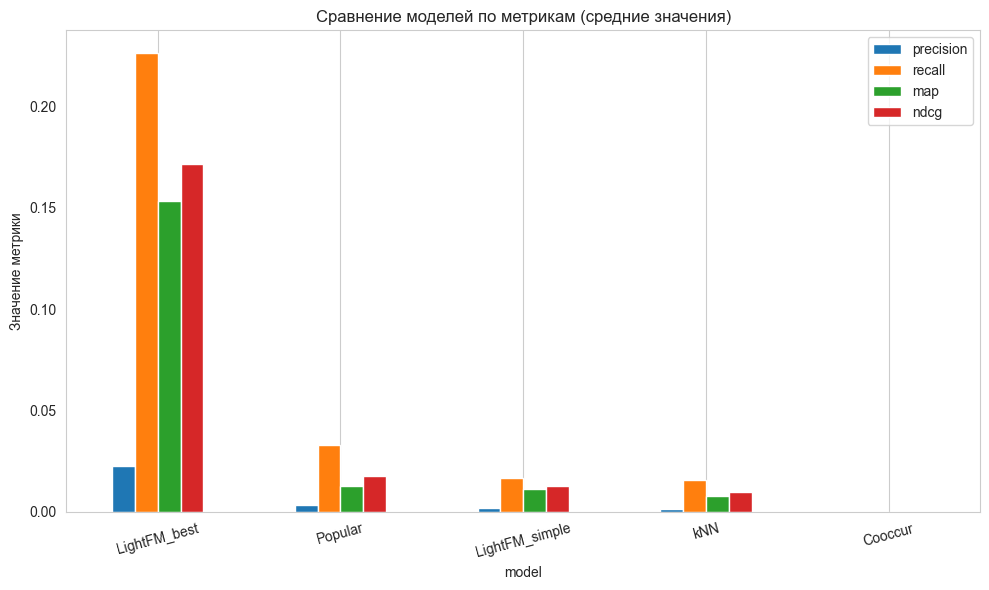

In [144]:
# Сравнительная таблица
summary = results_df.groupby('model')[['precision', 'recall', 'map', 'ndcg']].mean().sort_values('precision', ascending=False)
print(summary)

# Покрытие для Cooccur
not_empty_cooccur = results_df[results_df['model'] == 'Cooccur']['precision'].astype(bool).sum()
print(f'Покрытие Cooccur: {not_empty_cooccur}/{len(test_users)} пользователей получили рекомендации')

# Визуализация
summary[['precision', 'recall', 'map', 'ndcg']].plot(kind='bar', figsize=(10,6))
plt.title('Сравнение моделей по метрикам (средние значения)')
plt.ylabel('Значение метрики')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Вывод

**Анализ результатов:**

- LightFM_best (с оптимизацией гиперпараметров) уверенно лидирует по всем метрикам, что подтверждает преимущество матричной факторизации над простыми эвристиками.
- Popular и LightFM_simple показывают базовый уровень, заметно уступая LightFM_best.
- kNN и Cooccur показывают низкие метрики. Для Cooccur это связано с тем, что только 40–50% пользователей имеют более одной покупки в train, а значит, только для них возможны meaningful рекомендации.
- Для остальных моделей покрытие рекомендациями полное, но качество невысокое.
- Эти baseline-результаты — отправная точка для дальнейших улучшений (feature engineering, implicit feedback, гибридные подходы).

## Шаг 7. Выводы

**Основные инсайты:**
- LightFM_best лидирует по всем метрикам, что подтверждает эффективность матричной факторизации для рекомендательных систем с разреженными данными.
- Эвристические модели (Popular, Cooccur) просты в реализации, но ограничены по качеству, особенно при недостатке пользовательской истории.
- Покрытие рекомендациями у LightFM и Popular составляет 100%, у Cooccur — около 50%, что связано с недостаточной историей покупок у большинства пользователей.

**Связь метрик с бизнес-целями:**
- Рост Precision@K и Recall@K может напрямую привести к увеличению среднего чека и удержания пользователей, что критически важно для бизнеса.
- MAP и NDCG — ключевые метрики для оценки позиций релевантных товаров в рекомендательной выдаче, что влияет на удовлетворённость пользователей.

**Рекомендации:**
- Добавлять признаки товаров и пользователей, использовать implicit feedback (например, просмотры и добавления в корзину) для улучшения моделей.
- Применять гибридные подходы (совмещение content-based и collaborative filtering), чтобы преодолеть cold start для новых пользователей и товаров.
- Продолжить оптимизацию моделей и проводить анализ ошибок для поиска новых точек роста качества рекомендаций.